In [8]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd sjk012/datasets/ #Переход в директорию sjk012/datasets/
!bash get_datasets.sh #Выполнение скрипта get_datasets.sh, который скачивает набор данных CIFAR-10, если он ещё не существует.
%cd ../../

!pip install numpy matplotlib threadpoolctl imageio cython

# Download and install the OpenBLAS and BLIS libraries
%mkdir -p sjk012/software
%cd sjk012/software
%rm -rf blis
!git clone https://github.com/flame/blis.git 
%cd blis/
!./configure --prefix=${HOME}/install/blis --enable-cblas --enable-threading=openmp auto &> /dev/null
!make -j4 install 
%cd ..
%rm -rf OpenBLAS
!git clone https://github.com/OpenMathLib/OpenBLAS.git
%cd OpenBLAS
!make -j4 &> /dev/null
!make PREFIX=${HOME}/install/openblas install
%cd ../../../
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:${HOME}/install/blis/lib:${HOME}/install/openblas/lib

[Errno 2] No such file or directory: 'sjk012/datasets/ #Переход в директорию sjk012/datasets/'
/home/crayter/ML/sjk012-env/assignment1
bash: get_datasets.sh: No such file or directory


/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/crayter/ML
/home/crayter/ML/sjk012/software
Cloning into 'blis'...
remote: Enumerating objects: 52642, done.
remote: Counting objects: 100% (13485/13485), done.
remote: Compressing objects: 100% (1342/1342), done.
remote: Total 52642 (delta 12531), reused 12533 (delta 12139), pack-reused 39157
Receiving objects: 100% (52642/52642), 48.78 MiB | 19.60 MiB/s, done.
Resolving deltas: 100% (42756/42756), done.
/home/crayter/ML/sjk012/software/blis
Generating monolithic blis.hGenerating monolithic cblas.hInstalling blis.h helper header into /home/crayter/install/blis/include/
Installing cblas.h helper header into /home/crayter/install/blis/include/
Installing config.mk common.mk into /home/crayter/install/blis/share/blis/
Installing blis.pc into /home/crayter/install/blis/share/pkgconfig/
Installing config/haswell/make_defs.mk into /home/crayter/install/blis/share/blis/config/haswell
...............
.........Generated include/haswell/cblas.h
............................................

# Fully-Connected Neural Nets
In this first assignment we will implement and parallelise fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [9]:
# As usual, a bit of setup
from __future__ import print_function  #спользовать функцию print() из Python 3 в коде, написанном для Python 2.
import time
import numpy as np
import matplotlib.pyplot as plt
from sjk012.data_utils import get_CIFAR10_data
from sjk012.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from sjk012.solver import Solver
from sjk012.operations import *



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [10]:

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
 #используются для автоматической перезагрузки модулей перед выполнением кода. 
     #без необходимости перезапускать весь Jupyter Notebook.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

def rel_error(x, y):     #Эта функция вычисляет относительную ошибку между двумя массивами x и y,
                         # что полезно при проверке правильности реализации градиентов
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [12]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data() #таких как нормализация данных и разбиение на обучающую, валидационную и тестовую выборки.

for k, v in list(data.items()): #Для каждого ключа (например, X_train, X_val, X_test, y_train и т.д.) в 
                                #словаре data печатается его название и размеры соответствующих массивов данных. 
                                #Это дает представление о структуре данных, с которыми предстоит работать.
  print(('%s: ' % k, v.shape))

data['X_train']= data['X_train'].reshape(data['X_train'].shape[0], np.prod(data['X_train'].shape[1:])).astype(np.float32)
data['X_val']  = data['X_val'  ].reshape(data['X_val'  ].shape[0], np.prod(data['X_val'  ].shape[1:])).astype(np.float32)
data['X_test'] = data['X_test' ].reshape(data['X_test' ].shape[0], np.prod(data['X_test' ].shape[1:])).astype(np.float32)

#data['X_train'].shape[0]: Эта часть кода получает количество изображений в обучающем наборе данных. shape[0] 
#ссылается на первое измерение массива X_train, которое соответствует количеству изображений.

#data['X_train'].shape[1:]: Это получение размеров каждого изображения, начиная с первого измерения 
#(не включая измерение, соответствующее количеству изображений). 
#Для CIFAR-10 это обычно [32, 32, 3], где 32, 32 — это размеры изображения в пикселях, 
#а 3 — количество цветовых каналов (RGB).

#np.prod(data['X_train'].shape[1:]): np.prod() вычисляет произведение элементов в указанном массиве. 
#Здесь это применяется к размерам каждого изображения, эффективно превращая размеры [32, 32, 3] 
#в единственное число 3072 (32*32*3), что представляет собой общее количество пикселей (учитывая все цветовые каналы)
# в каждом изображении

#data['X_train'].reshape(data['X_train'].shape[0], np.prod(data['X_train'].shape[1:])): 
#Эта часть преобразует многомерный массив изображений в двумерный массив, где каждая строка представляет собой 
#одно изображение, вытянутое в одномерный вектор пикселей. 
#Размер нового массива будет [количество пикселей, 3072].

#.astype(np.float32): Это изменение типа данных элементов массива на float32

#В итоге, эта строка кода преобразует исходные трехмерные тензоры изображений CIFAR-10 
#в двумерные матрицы, где каждая строка матрицы соответствует вытянутому в вектор изображению, 
#и изменяет тип данных пикселей на float32.

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Naive matmul operator:
Open the file `sjk012/operations.py` and implement the `matmul_naive` function.

Once you are done you can test your implementation by running the following:

In [13]:
a_shape = (3, 5)
b_shape = (5, 4)
c_shape = (3, 4)

a = np.linspace(-0.1, 0.5, num=np.prod(a_shape), dtype=np.float32).reshape(a_shape)
b = np.linspace(-0.2, 0.3, num=np.prod(b_shape), dtype=np.float32).reshape(b_shape)
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)

c_out_naive = matmul_naive(a, b, c)

correct_c = np.array([[-0.2556391,  -0.22115516, -0.18667122, -0.15218729],
                      [-0.09890636, -0.03622693,  0.02645249,  0.08913192],
                      [ 0.05782638,  0.1487013,   0.23957621,  0.33045113]])

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_naive function:')
print('difference: ', rel_error(c_out_naive, correct_c))

Testing matmul_naive function:
difference:  2.6648552970039633e-07


# Numpy matmul operator:
Open the file `sjk012/operations.py` and implement the `matmul_numpy` function.

Once you are done you can test your implementation running the following code:

In [14]:
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)

c_out_np = matmul_numpy(a, b, c)

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_numpy function:')
print('difference: ', rel_error(c_out_np, correct_c))

Testing matmul_numpy function:
difference:  2.6648552970039633e-07


# cblas_gemm:
Open the file `sjk012/operations.py` and implement the `matmul_cblas` function in order to call to `cblas_sgemm` BLAS3 function. See: https://netlib.org/lapack/explore-html/de/da0/cblas_8h_a1446cddceb275e7cd299157a5d61d5e4.html

Here's a simple example demonstrating how to call an external function using ctypes:

```python
import ctypes

# Load the library containing the external function
libc = ctypes.CDLL('/path/to/your/library.so')  # Replace '/path/to/your/library.so' with the path to your library

# Define the argument types and return type of the external function
libc.my_external_function.argtypes = [ctypes.c_int, ctypes.c_int]
libc.my_external_function.restype = ctypes.c_int

# Call the external function
result = libc.my_external_function(3, 4)
```

Once you are done, add the location of the OpenBLAS and BLIS libraries to the `LD_LIBRARY_PATH` environment variable.

In [15]:
import os
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":" + os.environ['HOME'] + "/install/blis/lib:" + os.environ['HOME'] + "/install/openblas/lib"

Afterwards, you can test your implementation using OpenBLAS running the code below:

In [16]:
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)
openblas = load_library("openblas")

c_out_cblas = matmul_cblas(openblas, a, b, c)

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_cblas function:')
print('difference: ', rel_error(c_out_cblas, correct_c))

Testing matmul_cblas function:
difference:  2.6648552970039633e-07


Try the same as before but using the BLIS library: 

In [17]:
c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)
blis = load_library("blis")

c_out_cblas = matmul_cblas(blis, a, b, c)

# Compare your output with ours. The error should be around e-7 or less.
print('Testing matmul_cblas function:')
print('difference: ', rel_error(c_out_cblas, correct_c))

Testing matmul_cblas function:
difference:  2.6648552970039633e-07


# Tiled GEMM multiplication:

In this task, you will implement tiling for the inner loops of the GEMM operation. The idea is to divide the matrices into smaller tiles and then perform the multiplication on these tiles. The following pseudo-code and figure illustrate the concept of tiling for the inner loops of GEMM. You need to also parallelize the outer loop using OpenMP.

![Tiled GEMM](sjk012/img/tiled_gemm.png) 

Open the file `sjk012/tiled_gemm/tiled_gemm.pyx` and implement the `matmul_tiled_cython_inner`.

```
function matmul_tiled_cython_inner(A, B, C, M, N, K, blockSize):
    for m from 0 to M step blockSize:
        for n from 0 to N step blockSize:
            for k from 0 to K step blockSize:

                // Calculate upper bounds for each block
                mUpper = min(m + blockSize, M)
                nUpper = min(n + blockSize, N)
                kUpper = min(k + blockSize, K)

                for i from m to mUpper:
                    for j from n to nUpper:
                        temp = 0
                        for l from k to kUpper:
                            temp += A[i][l] * B[l][j]
                        C[i][j] += temp
end function
```

Use the `prange` function from Cython to parallelize the first loop via OpenMP. See https://cython.readthedocs.io/en/latest/src/userguide/parallelism.html

Open the file `sjk012/operations.py` and implement the `matmul_tiled` function in order to call to `tiled_gemm` function that you have just implemented. 

Afterwards, you can test your implementation running the code below. Note that the code will automatically compile the Cython module and will store it in `~/.pyxbld`. If you want to compile it manually, run `python
setup.py build_ext --inplace`.

In [18]:
%autoreload 2

c = np.linspace(-0.3, 0.1, num=np.prod(c_shape), dtype=np.float32).reshape(c_shape)

import pyximport
pyximport.install(reload_support=True, pyimport=True)
from sjk012.tiled_gemm.tiled_gemm import matmul_tiled_cython

c_out_tiled = matmul_tiled_cython(a, b, c, 32)
# Compare your output with ours. The error should be around e-7 or less.
#? What is the purpose of this check?
print('Testing matmul_tiled function:')
print('difference: ', rel_error(c_out_tiled, correct_c))

#Why not add something like this:
#if code is executed:
#add a line.
from numpy import allclose
# Проверка, равна ли rel_error(c_out_tiled, correct_c) 1
if allclose(rel_error(c_out_tiled, correct_c), 1):
    print("This is a good? or not? result, but you will learn how correct it is in the next chapter.")
#This is a good result, but you will learn how correct it is in the next chapter.
#Or initialize another matrix to check this part.

Testing matmul_tiled function:
difference:  1.0
This is a good? or not? result, but you will learn how correct it is in the next chapter.


# Tiled gemm block size performance evaluation:

Now that we have implemented the tiled GEMM, we have to evaluatethe optimal block size for the target machine. Try using differnet number of threads to see what could be the best option. 

*You can write here your conclusions:*

In [19]:
from sjk012.operations import *
from sjk012.fc_net import *
from threadpoolctl import threadpool_limits
import numpy as np
import time

# Create numpy arrays for matrices a, b, and c
m, n, k = 2048, 2048, 2048

a = np.random.rand(m, k).astype(np.float32)
b = np.random.rand(k, n).astype(np.float32)

with threadpool_limits(limits=8):
    tile_sizes = [4, 8, 16] #, 32, 64, 128, 256, 512] #подурежем осетра для ускорения

    ###########################################################################
    # TODO: Call the matmul_tiled_cython passing above defined tile_sizes     #
    # and obtain the execution time for each size                             #
    ###########################################################################
    for tile_size in tile_sizes:
        # Инициализация матрицы c нулями здесь
        c = np.zeros((m, n), dtype=np.float32)   
        
        start_time = time.time()
        
        # Вызов функции умножения с тайлингом
        c = matmul_tiled_cython(a, b, c, tile_size)
        
        # Измерение времени окончания и расчет длительности
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"Tile size: {tile_size}, Execution time: {duration:.4f} seconds")
        
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

Tile size: 4, Execution time: 33.4321 seconds
Tile size: 8, Execution time: 81.4009 seconds
Tile size: 16, Execution time: 395.8308 seconds


# Parallel performance evaluation

Now, evaluate the performance of the different versions using the corresponding parallel versions.

First, set the corresponding location of `libgomp.so` to the `LD_LIBRARY_PATH` environment variable (you would probably need to adjust the path where `libgomp.so` is located in your platform):

In [20]:
#Как же я раньше не догодался # Ну конечно же другая версия не 9 а 11
import os
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":" + "/usr/lib/gcc/x86_64-linux-gnu/11/"

In [73]:
from threadpoolctl import threadpool_limits
from pprint import pprint
import time

# Define matrix sizes
sizes = [2**i for i in range(4, 11)] # 12 - тоже неможко подрежем до 2в11 степени 2048 

# Number of repetitions
repetitions = 1
tile_size = 16

thread_range = [1, 2, 4, 8, 16, 24]

# Initialize arrays to store execution times
numpy_times = np.zeros((len(sizes), len(thread_range)))
openblas_times = np.zeros((len(sizes), len(thread_range)))
blis_times = np.zeros((len(sizes), len(thread_range)))
tiled_times = np.zeros((len(sizes), len(thread_range)))

numpy_times_m = np.zeros((len(sizes), len(thread_range)))
openblas_times_m = np.zeros((len(sizes), len(thread_range)))
blis_times_m = np.zeros((len(sizes), len(thread_range)))
tiled_times_m = np.zeros((len(sizes), len(thread_range)))

for num_threads, n_threads in enumerate(thread_range):
    with threadpool_limits(limits=n_threads):
        
        # Measure performance for each size
        for idx, size in enumerate(sizes):
            print(f"Matrix size: {size} x {size}, Threads: {n_threads}")

            # Initialize arrays to store execution times for current size
            numpy_times_size = []
            openblas_times_size = []
            blis_times_size = []
            tiled_times_size = []

            numpy_times_size_m = []
            openblas_times_size_m = []
            blis_times_size_m = []
            tiled_times_size_m = []

      
            for _ in range(repetitions):
                ###########################################################################
                # TODO: Call the corresponding versions of the matmul and append the times #
                # to the previously created vectors                                       #
                ###########################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****                  
                # Generate random matrices
                a = np.random.rand(size, size).astype(np.float32)
                b = np.random.rand(size, size).astype(np.float32)
                c = np.zeros((size, size), dtype=np.float32)
                
                # Measure performance of numpy implementation
                # NumPy
                start = time.time()
                matmul_numpy(a, b, c)
                numpy_times_size.append(time.time() - start)  # добавляем значение времени выполнения в массив
                numpy_times[idx, num_threads] = time.time() - start
                #print(f"Размер матрицы: {size}, Количество потоков: {num_threads}, Время выполнения: {numpy_times[idx, num_threads]}")
                numpy_times[idx, num_threads] = numpy_times_size[-1]

                # Measure performance of tiled implementation
                # Tiled GEMM
                #-- Если низ был бы по другму то можно было бы просто так как ниже 
                #start = time.time()
                #matmul_tiled_cython(a, b, c, tile_size)
                #tiled_times[idx, num_threads] = time.time() - start
                #-- А так прижеться 
                start = time.time()
                matmul_tiled_cython(a, b, c, tile_size)
                tiled_times_size.append(time.time() - start)
                tiled_times[idx, num_threads] = time.time() - start
                tiled_times[idx, num_threads] = tiled_times_size[-1]

                # Measure performance of cblas implementation with OpenBLAS
                # cblas_gemm with OpenBLAS
                start = time.time()
                matmul_cblas(openblas, a, b, c)
                openblas_times_size.append(time.time() - start)
                #openblas_times[idx, num_threads] = time.time() - start
                openblas_times[idx, num_threads] = time.time() - start
                openblas_times[idx, num_threads] = openblas_times_size[-1]

                # Measure performance of cblas implementation with BLIS
                # BLIS
                # cblas_gemm with BLIS
                start = time.time()
                matmul_cblas(blis, a, b, c)
                blis_times_size.append(time.time() - start)
                #blis_times[idx, num_threads] = time.time() - start
                blis_times[idx, num_threads] = time.time() - start
                blis_times[idx, num_threads] = blis_times_size[-1]

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                ###########################################################################
                #                             END OF YOUR CODE                            #
                ###########################################################################            
            ## ??? Зачем это тут это  это не работает ошибка и должно быть сдвинуто ????
            ### We have -only one- --execution time-- for current size and number of threads
            #### -for num_threads, n_threads in enumerate(thread_range):
            # Compute average execution times for current size and number of threads
            #numpy_times[idx, num_threads] = np.mean(numpy_times_size)
            #openblas_times[idx, num_threads] = np.mean(openblas_times_size)
            #blis_times[idx, num_threads] = np.mean(blis_times_size)
            #tiled_times[idx, num_threads] = np.mean(tiled_times_size)
   #_______---------------------------________________ 
   # И  выполненно так или совсем не нужно ??
        #numpy_times_m[idx, num_threads] = np.mean(numpy_times_size)
        #openblas_times_m[idx, num_threads] = np.mean(openblas_times_size)
        #blis_times_m[idx, num_threads] = np.mean(blis_times_size)
        #tiled_times_m[idx, num_threads] = np.mean(tiled_times_size)
# Так ка на печать выводятся графики зависимости numpy_times[idx, num_threads] которые  содержат время
# np.mean(numpy_times_size) Это столбцы среднего

Matrix size: 16 x 16, Threads: 1
Matrix size: 32 x 32, Threads: 1
Matrix size: 64 x 64, Threads: 1
Matrix size: 128 x 128, Threads: 1


Matrix size: 256 x 256, Threads: 1
Matrix size: 512 x 512, Threads: 1
Matrix size: 1024 x 1024, Threads: 1
Matrix size: 16 x 16, Threads: 2
Matrix size: 32 x 32, Threads: 2
Matrix size: 64 x 64, Threads: 2
Matrix size: 128 x 128, Threads: 2
Matrix size: 256 x 256, Threads: 2
Matrix size: 512 x 512, Threads: 2
Matrix size: 1024 x 1024, Threads: 2
Matrix size: 16 x 16, Threads: 4
Matrix size: 32 x 32, Threads: 4
Matrix size: 64 x 64, Threads: 4
Matrix size: 128 x 128, Threads: 4
Matrix size: 256 x 256, Threads: 4
Matrix size: 512 x 512, Threads: 4
Matrix size: 1024 x 1024, Threads: 4
Matrix size: 16 x 16, Threads: 8
Matrix size: 32 x 32, Threads: 8
Matrix size: 64 x 64, Threads: 8
Matrix size: 128 x 128, Threads: 8
Matrix size: 256 x 256, Threads: 8
Matrix size: 512 x 512, Threads: 8
Matrix size: 1024 x 1024, Threads: 8
Matrix size: 16 x 16, Threads: 16
Matrix size: 32 x 32, Threads: 16
Matrix size: 64 x 64, Threads: 16
Matrix size: 128 x 128, Threads: 16
Matrix size: 256 x 256, Threads:

In [74]:
numpy_times

array([[4.91142273e-04, 4.79221344e-05, 3.21865082e-05, 5.86509705e-05,
        2.59876251e-05, 3.26633453e-05],
       [1.64508820e-05, 1.35898590e-05, 1.19209290e-05, 1.54972076e-05,
        3.69548798e-05, 3.64780426e-05],
       [3.98159027e-05, 2.26497650e-05, 1.66893005e-05, 3.00407410e-05,
        4.38690186e-05, 4.60147858e-05],
       [1.11341476e-04, 1.62839890e-04, 1.99079514e-04, 2.53677368e-04,
        3.13758850e-03, 1.34708881e-02],
       [1.41572952e-03, 1.41882896e-03, 9.55820084e-04, 1.27482414e-03,
        2.67434120e-03, 3.35669518e-03],
       [7.04836845e-03, 4.25314903e-03, 3.20124626e-03, 2.24208832e-03,
        2.48789787e-03, 1.77903175e-02],
       [2.83973217e-02, 1.73652172e-02, 1.44493580e-02, 1.17990971e-02,
        1.45006180e-02, 4.68103886e-02]])

In [75]:
numpy_times_m

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

Test the code running the matmul implementations in parallel using OpenMP threads.

In [76]:
c_out_tiled = matmul_tiled_cython(a, b, c, 16) #32 to 16 For Speed up exe

Plot the execution times and observe the times of each matmul version running with different number of threads. 

Which version scales better with regards to the number of threads and matrix size? What is the most efficient?

*Write here your observations:*

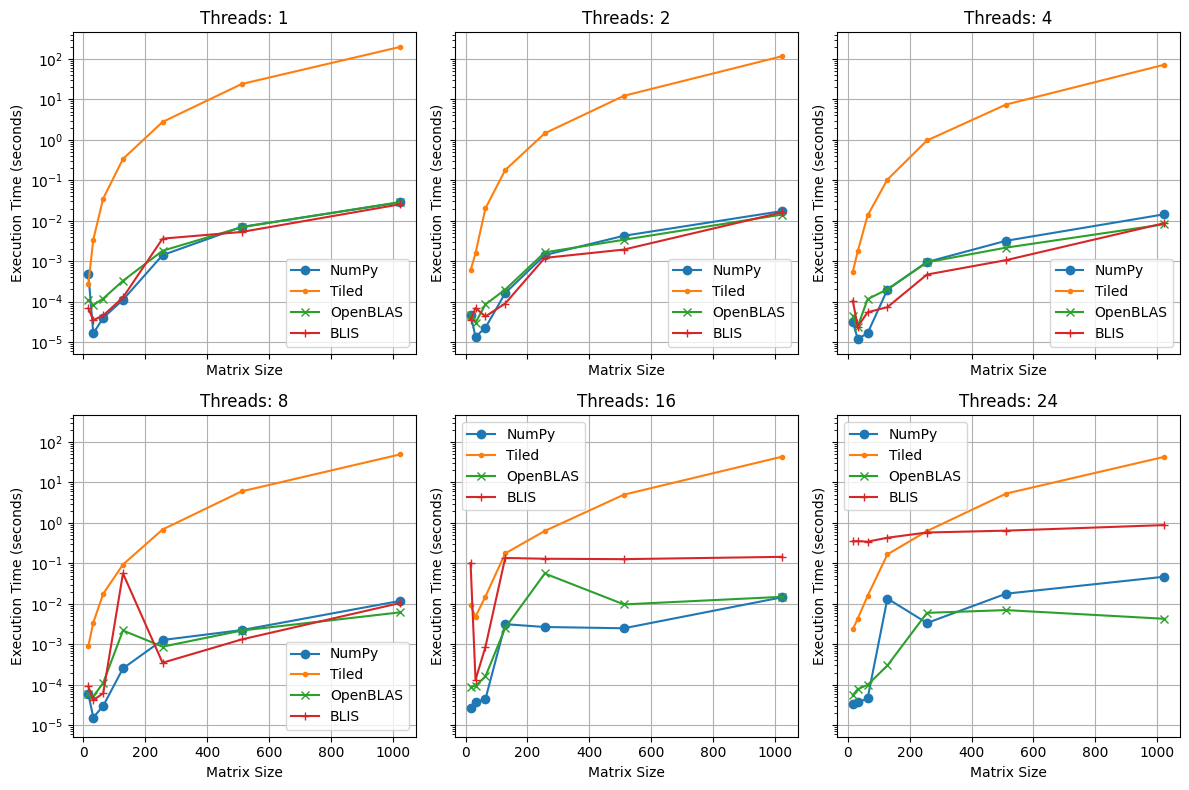

In [77]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    axs[row, col].plot(sizes, numpy_times[:, i], marker='o', label=f'NumPy')
    axs[row, col].plot(sizes, tiled_times[:, i], marker='.', label=f'Tiled')
    axs[row, col].plot(sizes, openblas_times[:, i], marker='x', label=f'OpenBLAS')
    axs[row, col].plot(sizes, blis_times[:, i], marker='+', label=f'BLIS')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix Size')
    axs[row, col].set_ylabel('Execution Time (seconds)')
    axs[row, col].legend()
    axs[row, col].set_yscale("log")
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

Plot now the speedups of the different matmul versions and write your observations.

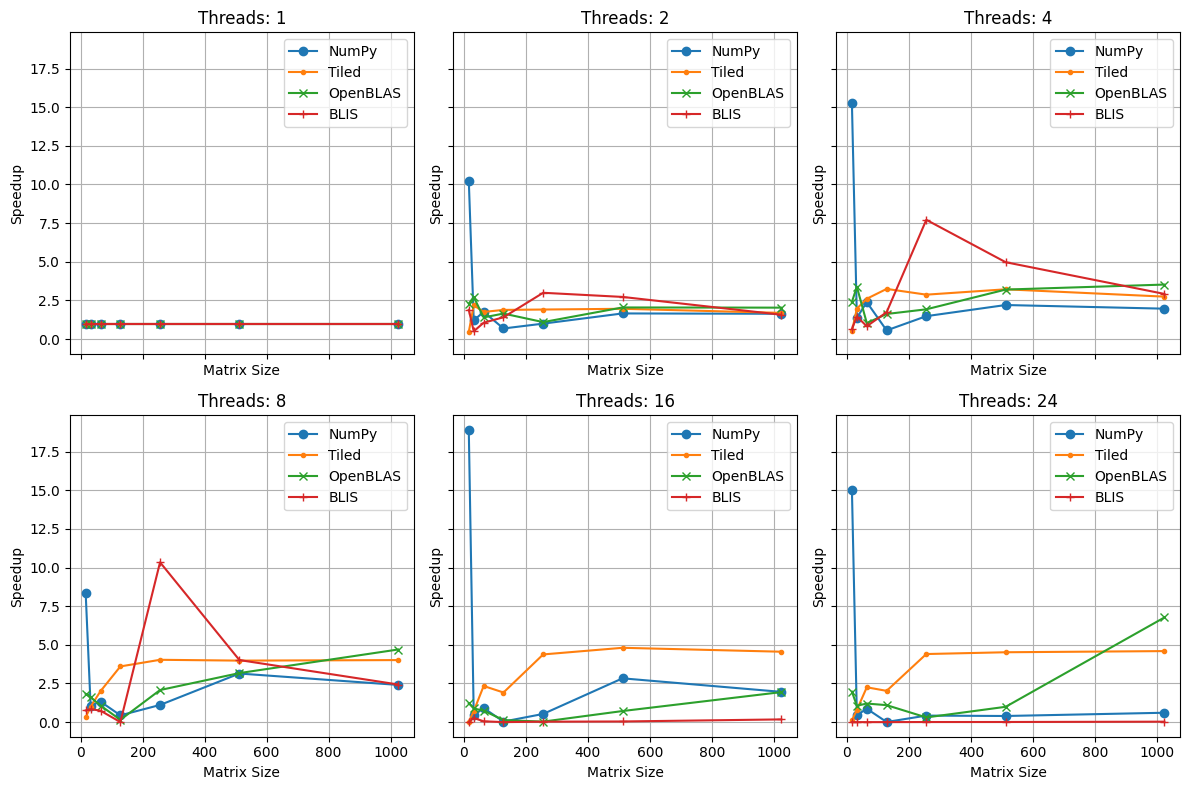

In [78]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    axs[row, col].plot(sizes, numpy_times[:, 0] / numpy_times[:, i], marker='o', label=f'NumPy')
    axs[row, col].plot(sizes, tiled_times[:, 0] / tiled_times[:, i], marker='.', label=f'Tiled')
    axs[row, col].plot(sizes, openblas_times[:, 0] / openblas_times[:, i], marker='x', label=f'OpenBLAS')
    axs[row, col].plot(sizes, blis_times[:, 0] / blis_times[:, i], marker='+', label=f'BLIS')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix Size')
    axs[row, col].set_ylabel('Speedup')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()


# Fully-Connected Layer: Forward Pass

To implement the forward pass for the fully-connected layer, open the file `sjk012/layers.py` and implement the `fc_forward` function. This function utilizes matrix multiplication (`matmul`) to perform the forward pass efficiently.

### Forward Pass Formula:

Given input data \($X$\), weights \($W$\), and biases \($b$\), the forward pass for the fully-connected layer can be defined as:

$$\text{out} = X \times W + b$$

### Implementation:

1. **Matrix Multiplication**: Perform matrix multiplication between input data \($X$\) and weights \($W$\).
2. **Add Bias**: Add the biases \($b$\) to the result of the matrix multiplication.

Once you complete the implementation of the `fc_forward` function, you can test its correctness by running the provided code.

 Веса и смещения являются параметрами слоя, которые обучаются в процессе обучения сети.

Матричное умножение: Это сердце полносвязного слоя, где векторизованные входные данные умножаются на матрицу весов. Это позволяет реализовать линейное преобразование входных данных.
Добавление смещения: После матричного умножения к каждому выходному нейрону добавляется смещение (bias). Это позволяет сдвигать линейное преобразование, делая модель более гибкой и способной аппроксимировать различные функции.

In [79]:
# Test the fc_forward function
from sjk012.layers import fc_forward

num_inputs = 2              #num_inputs: Количество входных примеров (или размер батча).
input_shape = (4, 5, 6)     #Форма каждого входного примера. В данном случае входные данные являются трехмерными, но для передачи в fc_forward они будут преобразованы в двумерный массив.
output_dim = 3              #размерность выхода полносвязного слоя, т.е., количество нейронов в слое.

#Генерация входных данных и параметров слоя:
input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

#x: Входные данные создаются с использованием функции np.linspace, которая генерирует значения в диапазоне от -0.1 до 0.5. 
#Затем эти данные преобразуются в форму, соответствующую (num_inputs, np.prod(input_shape)), 
#что представляет собой двумерный массив, где каждая строка является векторизованным представлением одного входного примера.
x = np.linspace(-0.1, 0.5, num=input_size, dtype=np.float32).reshape(num_inputs, np.prod(input_shape))

#Веса генерируются аналогичным образом и преобразуются в форму, соответствующую размеру (np.prod(input_shape), output_dim).
w = np.linspace(-0.2, 0.3, num=weight_size, dtype=np.float32).reshape(np.prod(input_shape), output_dim)

#b: Смещения (биасы) генерируются для каждого нейрона в выходном слое.
b = np.linspace(-0.3, 0.1, num=output_dim, dtype=np.float32)

# Функция fc_forward вызывается с входными данными x, весами w и смещениями b, чтобы получить выходные данные слоя.
out, _ = fc_forward(x, w, b)

#с заранее определенным правильным выходом correct_out
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing fc_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing fc_forward function:
difference:  5.2886153808560255e-08


# Fully-Connected Layer: Backward Pass

To implement the backward pass for the fully-connected layer, you need to open the file `sjk012/layers.py` and implement the `fc_backward` function.

### Backward Pass Formula:

The backward pass for the fully-connected layer involves computing gradients with respect to the input data \($X$\), weights \($W$\), and biases \($b$\). 

The gradients with respect to \($X$\), \($W$\), and \($b$\) can be computed using the chain rule and are given by:

$$\nabla X = \nabla Y \times W^T$$

$$\nabla W = X^T \times \nabla Y$$

$$\nabla b = \text{sum}(\nabla Y, axis=0)$$

Where \($L$\) is the loss function and \($\nabla Y$\) is the gradient of the loss with respect to the output of the fully-connected layer.

### Implementation:

1. **Gradient with Respect to Input**: Perform matrix multiplication between upstream gradient \($\nabla Y$\) and the transposed weights weights \($W^T$\).
2. **Gradient with Respect to Weights**: Perform matrix multiplication between transposed inputs \($X^T$\) and the upstream gradient \($\nabla Y$\).
3. **Gradient with Respect to Biases**: Compute the gradient with respect to biases \($\nabla b$\) using the formula above.

Once you complete the implementation of the `fc_backward` function, you can test its correctness using numeric gradient checking.


1 -использованием алгоритма обратного распространения ошибки. 

2 - Градиент по отношению к входу ($\nabla X$) показывает, как изменение входных данных повлияет на функцию потерь.
    Это значение используется для обновления параметров в предыдущих слоях нейронной сети.

3 - Градиент по отношению к весам ($\nabla W$) и градиент по отношению к смещениям ($\nabla b$) показывают, 
    как изменение этих параметров повлияет на функцию потерь. 
       
4 -  Эти значения используются для обновления весов и смещений в текущем слое.    

In [80]:
# Test the fc_backward function
from sjk012.layers import fc_backward

np.random.seed(12)
x = np.random.randn(10, 2, 3).astype(np.float32).reshape(10, 2*3)
w = np.random.randn(6, 5).astype(np.float32)
b = np.random.randn(5).astype(np.float32)
dy = np.random.randn(10, 5).astype(np.float32)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dy, h=1e-1)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dy, h=1e-1)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dy, h=1e-1)

_, cache = fc_forward(x, w, b)
dx, dw, db = fc_backward(dy, cache)

# The error should be around e-5 or less
print('Testing fc_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing fc_backward function:
dx error:  2.38993e-05
dw error:  1.8927357e-06
db error:  2.3024736e-06


# ReLU Activation: Forward Pass

To implement the forward pass for the ReLU activation function, you need to open the file `sjk012/layers.py` and implement the `relu_forward_numpy` function.

### Forward Pass Formula:

The forward pass for the ReLU activation function applies an element-wise operation to the input data \($X$\) and is given by:

$$Y = \text{max}(0, X)$$
$$\text{mask} = X > 0$$

### Implementation:

1. **Element-wise Operation**: Apply the ReLU function element-wise to the input data \($X$\), replacing negative values with zeros.
2. **Mask Calculation**: Calculate the mask $ \text{mask} = X > 0 $, which will be used for the backward pass to compute gradients.

Once you complete the implementation of the `relu_forward_numpy` function, you can test its correctness using the provided code.

1 - Прямой проход для функции активации ReLU применяет операцию поэлементно к входным данным $X$ и задается как:
ReLU задается как $$Y = \text{max}(0, X)$$
что для каждого элемента входного массива $X$ значение будет равно самому элементу, если он больше нуля, и нулю, если элемент меньше или равен нулю. Эта функция помогает устранить отрицательные значения из активаций нейронов и вносит нелинейность в модель, что критически важно для обучения сложных задач.

Расчет маски $$\text{mask} = X > 0$$
 важен для последующего обратного прохода, так как он определяет, какие нейроны были активны (т.е. их входы были больше нуля) во время прямого прохода. Эта информация используется при вычислении градиентов во время обратного прохода, поскольку градиенты для активных нейронов будут распространяться назад, а для неактивных нейронов (тех, которые не пропускали активацию) градиент будет равен нулю.
 
2 - Поэлементная операция: Примените функцию ReLU поэлементно к входным данным $X$, заменяя отрицательные значения нулями.

3 - Расчет маски: Рассчитайте маску $ \text{mask} = X > 0 $, которая будет использоваться при обратном проходе для вычисления градиентов.

In [81]:
# Test the relu_forward function
from sjk012.layers import relu_forward_numpy

x = np.linspace(-0.5, 0.5, num=12, dtype=np.float32).reshape(3, 4)

out, _ = relu_forward_numpy(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  3.5098836564329345e-08


### ReLU Activation: Forward Pass with Cython:

1. **Element-wise Operation**: Apply the ReLU function element-wise to the input data \( X \), replacing negative values with zeros.
2. **Parallelization**: Utilize OpenMP parallelization to efficiently compute the ReLU operation across multiple threads.

Once you complete the implementation of the forward pass in `relu_fwd.pyx`, you need to compile the Cython module containing this function. You can compile it by executing the provided code or by running `python setup.py build_ext --inplace` in the previous directory.


 1 - как ускорить вычисления прямого прохода используя Cython параллелизации через OpenMP
  ??Ну почему не писать модуль на С - если применям теорию строк или на Fortran если работаем со столбцами. 

In [82]:
%load_ext autoreload
%autoreload 2
# Test the relu_cython function
from sjk012.layers import relu_forward_cython

import pyximport
pyximport.install(reload_support=True, pyimport=True)
from sjk012.relu_fwd.relu_fwd import relu_fwd_cython

x = np.linspace(-0.5, 0.5, num=12, dtype=np.float32).reshape(3, 4)

out, _ = relu_forward_cython(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])


# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/crayter/ML/sjk012-env/assignment1/sjk012/relu_fwd/relu_fwd.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/crayter/.pyxbld/temp.linux-x86_64-cpython-311/home/crayter/ML/sjk012-env/assignment1/sjk012/relu_fwd/relu_fwd.c:1257:
/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using depreca

Testing relu_forward function:
difference:  3.5098836564329345e-08


# ReLU Parallel Performance Evaluation

To evaluate the performance of different versions of ReLU activation function using parallelization, follow these steps:

1. **Set Library Location**: Add the location of `libgomp.so` to the `LD_LIBRARY_PATH` environment variable. This ensures that the OpenMP library is accessible during execution.

2. **Performance Evaluation**: Compare the performance of different versions of ReLU activation function with and without parallelization. Measure execution times for each version and observe the impact of parallelization on speedup.

Below is a sample code snippet demonstrating how to set the library location and perform performance evaluation:


расположение libgomp.so в переменную окружения LD_LIBRARY_PATH. Это обеспечивает доступность библиотеки OpenMP во время выполнения.

Оценка Производительности: Сравните производительность различных версий функции активации ReLU с параллелизацией и без неё. Измерьте время выполнения для каждой версии и наблюдайте влияние параллелизации на ускорение

In [83]:
# Ну конечно же другая версия не 9 а 11
os.environ['LD_LIBRARY_PATH'] = os.environ['LD_LIBRARY_PATH'] + ":" + "/usr/lib/gcc/x86_64-linux-gnu/11/"

In [84]:
from threadpoolctl import threadpool_limits
from pprint import pprint

from sjk012.relu_fwd.relu_fwd import relu_fwd_cython
from sjk012.layers import relu_forward_numpy

# Define matrix sizes
sizes = [2**i for i in range(4, 14)]

# Number of repetitions Количество повторений
repetitions = 10

thread_range = [1, 2, 4, 8, 16, 24] # Диапазон потоков для тестирования

# Initialize arrays to store execution times для хранения времени выполнения
relu_numpy_times = np.zeros((len(sizes), len(thread_range)))
relu_cython_times = np.zeros((len(sizes), len(thread_range)))

for num_threads, n_threads in enumerate(thread_range):
    with threadpool_limits(limits=n_threads):
        
        # Measure performance for each size
        # Инициализация массивов для хранения времени выполнения текущего размера
        for idx, size in enumerate(sizes):
            print(f"Matrix size: {size} x {size}, Threads: {n_threads}")

            # Initialize arrays to store execution times for current size
            # Инициализация массивов для хранения времени выполнения текущего размера
            relu_numpy_times_size = []
            relu_cython_times_size = []

            for _ in range(repetitions):
                ###########################################################################
                # TODO: Call the corresponding versions of the relu and append the times  #
                # to the previously created vectors                                       #
                ###########################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****                  
                # Generate random matrices
                # Генерация случайных матриц
                x = np.random.randn(size, size).astype(np.float32)
                
                # Measure performance of numpy implementation
                # Измерение производительности реализации NumPy
                start_time = time.time()
                relu_forward_numpy(x)
                relu_numpy_times_size.append(time.time() - start_time)

                # Measure performance of tiled implementation
                # Измерение производительности реализации Cython
                start_time = time.time()
                relu_forward_cython(x)
                relu_cython_times_size.append(time.time() - start_time)

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                ###########################################################################
                #                             END OF YOUR CODE                            #
                ###########################################################################            

            # Compute average execution times for current size and number of threads
            relu_numpy_times[idx, num_threads] = np.mean(relu_numpy_times_size)
            relu_cython_times[idx, num_threads] = np.mean(relu_cython_times_size)

# Вывод результатов
print("NumPy ReLU times:")
pprint(relu_numpy_times)
print("Cython ReLU times:")
pprint(relu_cython_times)


Matrix size: 16 x 16, Threads: 1
Matrix size: 32 x 32, Threads: 1
Matrix size: 64 x 64, Threads: 1
Matrix size: 128 x 128, Threads: 1
Matrix size: 256 x 256, Threads: 1
Matrix size: 512 x 512, Threads: 1
Matrix size: 1024 x 1024, Threads: 1
Matrix size: 2048 x 2048, Threads: 1
Matrix size: 4096 x 4096, Threads: 1
Matrix size: 8192 x 8192, Threads: 1
Matrix size: 16 x 16, Threads: 2
Matrix size: 32 x 32, Threads: 2
Matrix size: 64 x 64, Threads: 2
Matrix size: 128 x 128, Threads: 2
Matrix size: 256 x 256, Threads: 2
Matrix size: 512 x 512, Threads: 2
Matrix size: 1024 x 1024, Threads: 2
Matrix size: 2048 x 2048, Threads: 2
Matrix size: 4096 x 4096, Threads: 2
Matrix size: 8192 x 8192, Threads: 2
Matrix size: 16 x 16, Threads: 4
Matrix size: 32 x 32, Threads: 4
Matrix size: 64 x 64, Threads: 4
Matrix size: 128 x 128, Threads: 4
Matrix size: 256 x 256, Threads: 4
Matrix size: 512 x 512, Threads: 4
Matrix size: 1024 x 1024, Threads: 4
Matrix size: 2048 x 2048, Threads: 4
Matrix size: 4096 

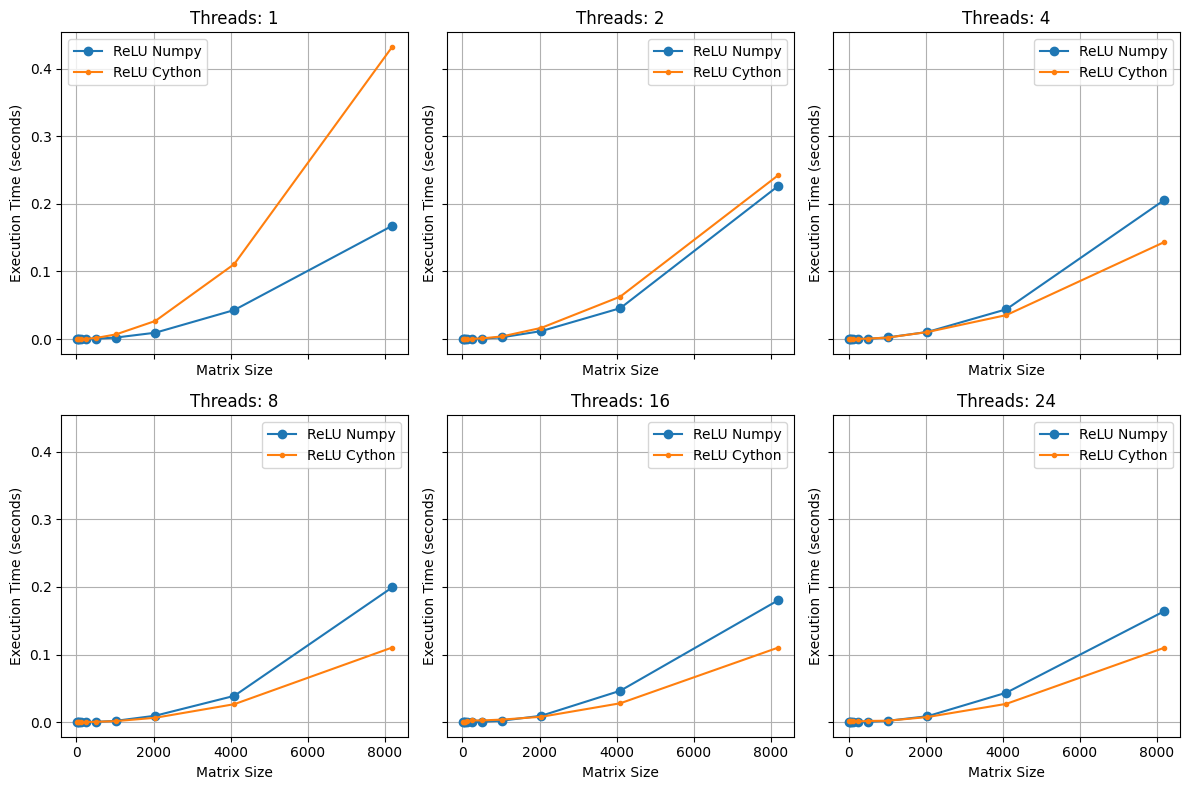

In [85]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    axs[row, col].plot(sizes, relu_numpy_times[:, i], marker='o', label=f'ReLU Numpy')
    axs[row, col].plot(sizes, relu_cython_times[:, i], marker='.', label=f'ReLU Cython')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix Size')
    axs[row, col].set_ylabel('Execution Time (seconds)')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

# ReLU Activation: Backward Pass

To implement the backward pass for the ReLU activation function, open the file `sjk012/layers.py` and implement the `relu_backward` function.

### Backward Pass Formula:

The backward pass for the ReLU activation function involves computing the gradient with respect to the input \($X$\). The gradient is given by:

$$\nabla X = \nabla Y \cdot \text{mask}$$

Where $ \nabla Y $ is the upstream gradient and $ \text{mask} $ is a binary mask indicating which elements of the input were positive during the forward pass.

### Implementation:

1. **Gradient with Respect to Input**: Compute the gradient with respect to the input data \($\nabla X$\) using the formula above.

Once you complete the implementation of the `relu_backward` function, you can test its correctness using numeric gradient checking.

Обратный проход для функции активации ReLU включает вычисление градиента по отношению к входу $X$. Градиент задается как: $$\nabla X = \nabla Y \cdot \text{mask}$$
Где $ \nabla Y $ — это градиент "сверху", а $ \text{mask} $ — это бинарная маска, указывающая, какие элементы входа были положительными во время прямого прохода.

1 - Во время обратного прохода, когда градиенты распространяются обратно по сети для
    обновления весов, важно учитывать, какие нейроны были активны -- имели положительные значения -- во время прямого прохода.

2 - Маска ($ \text{mask} $), созданная во время прямого прохода, указывает на активные нейроны, позволяя градиенту проходить только через них. 

3 - Таким образом, градиент по отношению к входу ($ \nabla X $) вычисляется как произведение градиента "сверху" ($ \nabla Y $) и маски ($ \text{mask} $).

In [86]:
from sjk012.layers import relu_backward_numpy

np.random.seed(12)
x = np.random.randn(10, 10).astype(np.float32)
dy = np.random.randn(*x.shape).astype(np.float32)

dy_num = eval_numerical_gradient_array(lambda x: relu_forward_numpy(x)[0], x, dy, h=1e-3)

_, cache = relu_forward_numpy(x)
dy = relu_backward_numpy(dy, cache)

# The error should be on the order of e-5
print('Testing relu_backward function:')
print('dx error: ', rel_error(dy_num, dy))

Testing relu_backward function:
dx error:  3.6239555e-05


### ReLU Activation: --Forward Pass with Cython:
### Не правильно тут  --Backward-- !!!!
To implement the backward pass for the ReLU activation function using Cython, follow these steps:

1. **Element-wise Operation**: Compute the gradient of the loss with respect to the input \($\nabla X$\) by multiplying the gradient of the loss with respect to the output of the ReLU layer by a binary mask. This mask should indicate which elements of the input were positive during the forward pass.

2. **Parallelization**: Utilize OpenMP parallelization to efficiently compute the backward pass operation across multiple threads.

Once you complete the implementation of the backward pass in `relu_bwd.pyx`, you need to compile the Cython module containing this function. You can compile it by executing the provided code or by running `python setup.py build_ext --inplace` in the previous directory.

In [87]:
%reload_ext autoreload
# Test the relu_backward function
from sjk012.layers import relu_backward_cython

import pyximport
pyximport.install(reload_support=True, pyimport=True)
from sjk012.relu_bwd.relu_bwd import relu_bwd_cython

np.random.seed(12)
x = np.random.randn(10, 10).astype(np.float32)
dy = np.random.randn(*x.shape).astype(np.float32)

dy_num = eval_numerical_gradient_array(lambda x: relu_forward_cython(x)[0], x, dy, h=1e-3)

_, cache = relu_forward_cython(x)
dy = relu_backward_cython(dy, cache)

# The error should be on the order of e-5
print('Testing relu_forward function:')
print('dx error: ', rel_error(dy_num, dy))

/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/crayter/ML/sjk012-env/assignment1/sjk012/relu_bwd/relu_bwd.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/crayter/.pyxbld/temp.linux-x86_64-cpython-311/home/crayter/ML/sjk012-env/assignment1/sjk012/relu_bwd/relu_bwd.c:1257:
/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using depreca

Testing relu_forward function:
dx error:  3.6239555e-05


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, fully-connected layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `sjk012/layer_utils.py`.

For now take a look at the `fc_relu_forward` and `fc_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [88]:
from sjk012.layer_utils import fc_relu_forward, fc_relu_backward

np.random.seed(12)
x = np.random.randn(2, 12).astype(np.float32)
w = np.random.randn(12, 10).astype(np.float32)
b = np.random.randn(10).astype(np.float32)
dy = np.random.randn(2, 10).astype(np.float32)

y, cache = fc_relu_forward(x, w, b)
dx, dw, db = fc_relu_backward(dy, cache)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dy, h=1e-1)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dy, h=1e-1)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dy, h=1e-2)

# Relative error should be around e-3 or less
print('Testing fc_relu_forward and fc_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing fc_relu_forward and fc_relu_backward:
dx error:  0.0003048242
dw error:  0.00010519987
db error:  2.5102025e-05


# Loss layers: Softmax
Now you have to implement the loss and gradient for the softmax in the `softmax_loss` function in `sjk012/layers.py`.

### Implementation
Follow these steps to implement the provided code:

1. **Compute the Softmax Probabilities**:

   The softmax probabilities $ P $ for each class $ i $ are computed as follows:

   $$ P_i = \frac{e^{x_i - \max(x)}}{\sum_{j} e^{x_j - \max(x)}} $$

   Where:
   - $ x $ is the input matrix of shape $(N, C)$ where $ N $ is the number of samples and $ C $ is the number of classes.
   - $ \max(x) $ computes the maximum value along each sample's row to improve numerical stability.

2. **Compute the Softmax Loss**:

   The softmax loss is calculated as the average cross-entropy loss over all samples:

   $$ \text{loss} = -\frac{1}{N}\sum_{i=1}^{N} \log(P_{i, y_i}) $$

   Where:
   - $ N $ is the number of samples.
   - $ y_i $ is the true label of sample $ i $.
   - $ P_{i, y_i} $ denotes the predicted probability of the true class for sample $ i $.

3. **Compute the Softmax Gradient**:

   The gradient of the softmax loss with respect to the input scores $ x $ is given by:

   $$ \frac{\partial L}{\partial x_i} = \frac{1}{N} (P_i - \text{one\_hot}(y_i)) $$

   Where:
   - $ P_i $ is the predicted probability of class $ i $.
   - $ \text{one\_hot}(y_i) $ is a one-hot encoded vector representing the true class of sample $ i $.
   - $ N $ is the number of samples, and dividing by $ N $ ensures averaging the gradients across all samples.
    
You can make sure that the implementations are correct by running the following:

Во время обратного прохода, необходимо вычислить, как изменение каждого входного значения влияет на конечные потери сети, что делается путем вычисления градиентов. Для ReLU это особенно просто: градиенты от верхних слоев пропускаются только через те нейроны, которые были активны (то есть имели положительные значения) во время прямого прохода. Это достигается с помощью маски активации 
mask
mask, которая и создается во время прямого прохода.

Подход, использующий "сэндвич" слои, упрощает построение нейронных сетей, так как часто используемые последовательности слоев, такие как полносвязный слой, за которым следует слой ReLU, могут быть легко реализованы и повторно использованы. Это также упрощает процесс обучения и позволяет более четко структурировать и понимать архитектуру сети.

In [89]:
from sjk012.layers import softmax_loss

np.random.seed(12)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes).astype(np.float32)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False, h=1e-1)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-3
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.3024002075195313
dx error:  0.0008857705


# Two-layer network
Open the file `sjk012/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [90]:
import numpy as np
from sjk012.fc_net import TwoLayerNet

np.random.seed(12)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D).astype(np.float32)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H).astype(np.float32)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H).astype(np.float32)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C).astype(np.float32)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C).astype(np.float32)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T.astype(np.float32)
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
print(scores_diff)
assert scores_diff < 1e-4, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
print(abs(loss - correct_loss))
assert abs(loss - correct_loss) < 1e-6, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
print(abs(loss - correct_loss))
assert abs(loss - correct_loss) < 1e-6, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-2)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
4.4409467772510425e-05
Testing training loss (no regularization)
2.929982749755311e-07
1.0232483660388425e-07
Running numeric gradient check with reg =  0.0
W1 relative error: 6.59e-03
W2 relative error: 2.91e-04
b1 relative error: 5.36e-03
b2 relative error: 1.08e-04
Running numeric gradient check with reg =  0.7
W1 relative error: 2.18e-01
W2 relative error: 2.00e-02
b1 relative error: 5.36e-03
b2 relative error: 1.08e-04


# Solver
Open the file `sjk012/solver.py` and read through it to familiarize yourself with the API. You also need to implement the `sgd` function in `sjk012/optim.py`. The Stochastic Gradient Descent (SGD) formula is:

$$W_{t+1} = W_t - \eta \cdot \nabla W$$

where:
- $W_t$ are the weights/biases at time step $t$,
- $\eta$ is the learning rate,
- $\nabla W_t$ is the gradient of the loss function with respect to weights/biases.

After implementing the SGD function, use a Solver instance to train a TwoLayerNet that achieves about 36% accuracy on the validation set.

Откройте файл sjk012/solver.py и ознакомьтесь с его API. Также вам нужно реализовать функцию sgd в файле sjk012/optim.py. Формула стохастического градиентного спуска (SGD) выглядит следующим образом:

где: $$W_{t+1} = W_t - \eta \cdot \nabla W$$

$W_t$ - веса/смещения на временном шаге $t$,
$\eta$ - скорость обучения,
$\nabla W_t$ - градиент функции потерь по отношению к весам/смещениям.
После реализации функции SGD используйте экземпляр Solver для обучения TwoLayerNet, который достигает примерно 36% точности на валидационном наборе данных.

Стохастический Градиентный Спуск (SGD) является одним из основных алгоритмов для оптимизации параметров нейронной сети. В его основе лежит идея постепенного обновления весов модели в направлении, противоположном градиенту функции потерь, что позволяет минимизировать значение функции потерь и, таким образом, улучшать производительность модели.
Для достижения  точности модели на валидационном наборе, важно тщательно подобрать гиперпараметры обучения, -- скорость обучения (learning rate), силу регуляризации, размер мини-батча и количество эпох обучения

In [93]:
from threadpoolctl import threadpool_limits

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 40% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Параметры для Solver
solver_config = {
    'update_rule': 'sgd',
    'optim_config': {
        'learning_rate': 1e-3,
    },
    'lr_decay': 0.95,
    'num_epochs': 20,
    'batch_size': 200,
    'print_every': 10,
    'verbose': True,
}

# Создание и использование экземпляра Solver для обучения модели
solver = Solver(model, data, **solver_config)
solver.train()

# Печать лучшей достигнутой точности на валидационном наборе
print("Лучшая достигнутая точность на валидационном наборе: {:.2f}%".format(solver.best_val_acc * 100))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.301925


(Epoch 0 / 20) train acc: 0.139000; val_acc: 0.142000
(Iteration 11 / 4900) loss: 2.251645
(Iteration 21 / 4900) loss: 2.126981
(Iteration 31 / 4900) loss: 2.027180
(Iteration 41 / 4900) loss: 1.999876
(Iteration 51 / 4900) loss: 1.964182
(Iteration 61 / 4900) loss: 2.057634
(Iteration 71 / 4900) loss: 1.842233
(Iteration 81 / 4900) loss: 1.885035
(Iteration 91 / 4900) loss: 1.765655
(Iteration 101 / 4900) loss: 1.735242
(Iteration 111 / 4900) loss: 1.789790
(Iteration 121 / 4900) loss: 1.759522
(Iteration 131 / 4900) loss: 1.679174
(Iteration 141 / 4900) loss: 1.782413
(Iteration 151 / 4900) loss: 1.784260
(Iteration 161 / 4900) loss: 1.703528
(Iteration 171 / 4900) loss: 1.650182
(Iteration 181 / 4900) loss: 1.635659
(Iteration 191 / 4900) loss: 1.729444
(Iteration 201 / 4900) loss: 1.719472
(Iteration 211 / 4900) loss: 1.644233
(Iteration 221 / 4900) loss: 1.596782
(Iteration 231 / 4900) loss: 1.664349
(Iteration 241 / 4900) loss: 1.604688
(Epoch 1 / 20) train acc: 0.424000; val_acc

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of more than 0.40 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

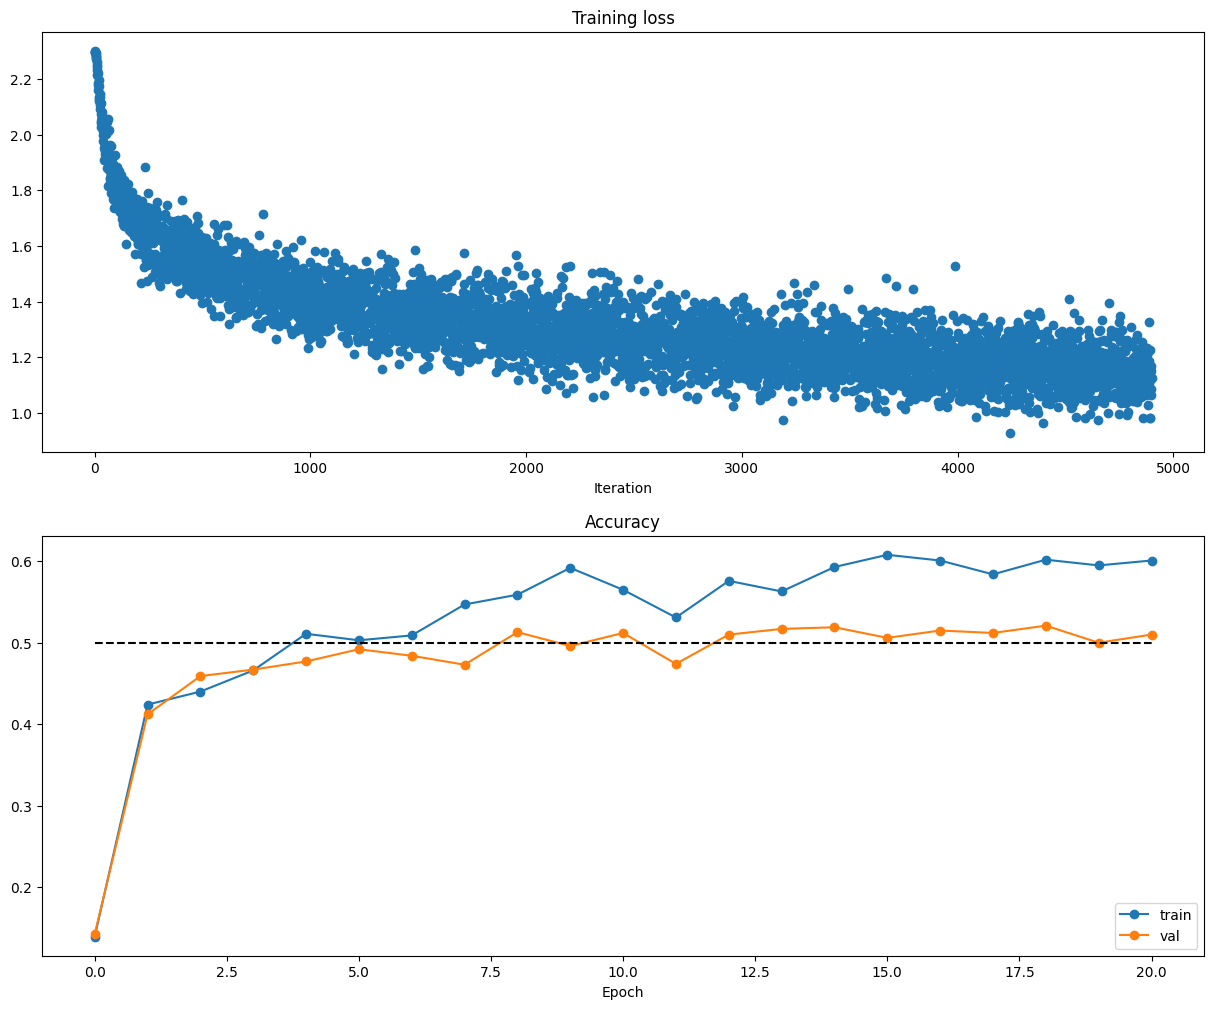

In [94]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

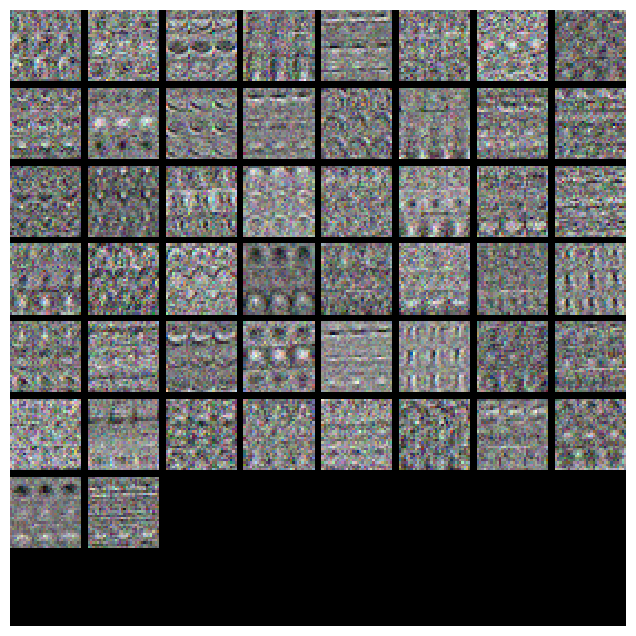

In [95]:
from sjk012.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Hyperparameter Tuning with Multi-threading

To expedite the hyperparameter search process, consider leveraging multiple threads to train your model. 

As indicated by the linear decrease in loss and lack of gap between training and validation accuracy, adjustments to hyperparameters such as learning rate, model size, batch size, and regularization strength may be necessary.

**Experimentation and Tuning**: Look a the hyperparameters including hidden layer size, learning rate, number of training epochs, batch size, and regularization strength. You may also explore tuning the learning rate decay, although satisfactory performance can often be achieved with the default value.

**Target Performance**: Aim for a classification accuracy exceeding 48% on the validation set, with the best networks achieving over 52%.

**Goal**: Your objective is to achieve optimal performance on CIFAR-10 with a fully-connected Neural Network. Use experimentation and hyperparameter tuning to iteratively refine your model's performance.


In [104]:

best_model = None


results = {}
best_val = -1

learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)

import itertools

#################################################################################
# TODO: Parallelise the hyperparmeter search procedure                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Подготовка к параллельному выполнению задач
from concurrent.futures import ThreadPoolExecutor, as_completed
futures = []
with ThreadPoolExecutor(max_workers=16) as executor:  # установить количество потоков в соответствии с ресурсами
    for lr, reg in itertools.product(learning_rates, regularization_strengths):
        # Создание задачи для каждой комбинации гиперпараметров
        #task = lambda lr=lr, reg=reg: (lr, reg, TwoLayerNet(hidden_dim=128, reg=reg), Solver(TwoLayerNet(hidden_dim=128, reg=reg), data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=False))
        def create_task(lr, reg):
            model = TwoLayerNet(hidden_dim=128, reg=reg)
            solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=True)
            return lr, reg, model, solver

        task = lambda lr=lr, reg=reg: create_task(lr, reg)
        futures.append(executor.submit(task))

    # Ожидание завершения всех задач и сбор результатов
    for future in as_completed(futures):
        lr, reg, model, solver = future.result()
        solver.train()

        # Вычисление точности на валидационном наборе и сохранение результатов
        val_acc = solver.best_val_acc
        results[(lr, reg)] = val_acc

        # Сохранение модели, если она показала лучшую точность на валидационном наборе
        if val_acc > best_val:
            best_val = val_acc
            best_model = model


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
    for lr, reg in itertools.product(learning_rates, regularization_strengths):
        # Create Two Layer Net and train it with Solver
        model = TwoLayerNet(hidden_dim=128, reg=reg)
        solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=True)
        solver.train()
    
        # Compute validation set accuracy and append to the dictionary
        results[(lr, reg)] = solver.best_val_acc

        # Save if validation accuracy is the best
        if results[(lr, reg)] > best_val:
            best_val = results[(lr, reg)]
            best_model = model

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


(Iteration 1 / 4900) loss: 2.301652
(Epoch 0 / 10) train acc: 0.096000; val_acc: 0.104000
(Iteration 11 / 4900) loss: 2.290981
(Iteration 21 / 4900) loss: 2.272621
(Iteration 31 / 4900) loss: 2.237086
(Iteration 41 / 4900) loss: 2.209603
(Iteration 51 / 4900) loss: 2.186929
(Iteration 61 / 4900) loss: 2.172873
(Iteration 71 / 4900) loss: 2.055443
(Iteration 81 / 4900) loss: 2.038741
(Iteration 91 / 4900) loss: 2.049214
(Iteration 101 / 4900) loss: 2.041469
(Iteration 111 / 4900) loss: 1.958540
(Iteration 121 / 4900) loss: 1.965160
(Iteration 131 / 4900) loss: 1.942086
(Iteration 141 / 4900) loss: 1.903094
(Iteration 151 / 4900) loss: 1.894054
(Iteration 161 / 4900) loss: 2.051308
(Iteration 171 / 4900) loss: 1.947553
(Iteration 181 / 4900) loss: 1.928169
(Iteration 191 / 4900) loss: 2.002587
(Iteration 201 / 4900) loss: 1.942048
(Iteration 211 / 4900) loss: 1.863713
(Iteration 221 / 4900) loss: 1.950269
(Iteration 231 / 4900) loss: 1.780261
(Iteration 241 / 4900) loss: 1.859983
(Iterat

/home/crayter/ML/sjk012-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(Iteration 1411 / 4900) loss: inf


/home/crayter/ML/sjk012-env/assignment1/sjk012/layers.py:302: RuntimeWarning: overflow encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)
/home/crayter/ML/sjk012-env/assignment1/sjk012/layers.py:302: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)


(Iteration 1421 / 4900) loss: nan
(Iteration 1431 / 4900) loss: nan
(Iteration 1441 / 4900) loss: nan
(Iteration 1451 / 4900) loss: nan
(Iteration 1461 / 4900) loss: nan
(Epoch 3 / 10) train acc: 0.097000; val_acc: 0.087000
(Iteration 1471 / 4900) loss: nan
(Iteration 1481 / 4900) loss: nan
(Iteration 1491 / 4900) loss: nan
(Iteration 1501 / 4900) loss: nan
(Iteration 1511 / 4900) loss: nan
(Iteration 1521 / 4900) loss: nan
(Iteration 1531 / 4900) loss: nan
(Iteration 1541 / 4900) loss: nan
(Iteration 1551 / 4900) loss: nan
(Iteration 1561 / 4900) loss: nan
(Iteration 1571 / 4900) loss: nan
(Iteration 1581 / 4900) loss: nan
(Iteration 1591 / 4900) loss: nan
(Iteration 1601 / 4900) loss: nan
(Iteration 1611 / 4900) loss: nan
(Iteration 1621 / 4900) loss: nan
(Iteration 1631 / 4900) loss: nan
(Iteration 1641 / 4900) loss: nan
(Iteration 1651 / 4900) loss: nan
(Iteration 1661 / 4900) loss: nan
(Iteration 1671 / 4900) loss: nan
(Iteration 1681 / 4900) loss: nan
(Iteration 1691 / 4900) loss

/home/crayter/ML/sjk012-env/assignment1/sjk012/fc_net.py:90: RuntimeWarning: overflow encountered in scalar add
  loss += 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2))


(Iteration 21 / 4900) loss: nan
(Iteration 31 / 4900) loss: nan
(Iteration 41 / 4900) loss: nan
(Iteration 51 / 4900) loss: nan
(Iteration 61 / 4900) loss: nan
(Iteration 71 / 4900) loss: nan
(Iteration 81 / 4900) loss: nan
(Iteration 91 / 4900) loss: nan
(Iteration 101 / 4900) loss: nan
(Iteration 111 / 4900) loss: nan
(Iteration 121 / 4900) loss: nan
(Iteration 131 / 4900) loss: nan
(Iteration 141 / 4900) loss: nan
(Iteration 151 / 4900) loss: nan
(Iteration 161 / 4900) loss: nan
(Iteration 171 / 4900) loss: nan
(Iteration 181 / 4900) loss: nan
(Iteration 191 / 4900) loss: nan
(Iteration 201 / 4900) loss: nan
(Iteration 211 / 4900) loss: nan
(Iteration 221 / 4900) loss: nan
(Iteration 231 / 4900) loss: nan
(Iteration 241 / 4900) loss: nan
(Iteration 251 / 4900) loss: nan
(Iteration 261 / 4900) loss: nan
(Iteration 271 / 4900) loss: nan
(Iteration 281 / 4900) loss: nan
(Iteration 291 / 4900) loss: nan
(Iteration 301 / 4900) loss: nan
(Iteration 311 / 4900) loss: nan
(Iteration 321 / 4

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [105]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.533


In [106]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.517
 0.517
